In [1]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import os
import wikipedia
import numpy as np
import requests

In [2]:
base_path = '/data/cap_images/'
unknown_base_path = "/data/face_recognition/unknown_face/"
known_base_path = "/data/face_recognition/known_face/"

# Get the coordinates

In [3]:
def get_exif(filename):
    exif = Image.open(filename)._getexif()

    if exif is not None:
        for key, value in exif.items():
            name = TAGS.get(key, key)
            exif[name] = exif.pop(key)

        if 'GPSInfo' in exif:
            for key in exif['GPSInfo'].keys():
                name = GPSTAGS.get(key,key)
                exif['GPSInfo'][name] = exif['GPSInfo'].pop(key)

    return exif

In [4]:
def get_decimal_coordinates(info):
    for key in ['Latitude', 'Longitude']:
        if 'GPS'+key in info and 'GPS'+key+'Ref' in info:
            e = info['GPS'+key]
            ref = info['GPS'+key+'Ref']
            degrees = e[0]
            minutes = e[1]/60.0
            seconds = e[2]/3600.0

            if ref in ['S', 'W']:
                degrees = -degrees
                minutes = -minutes
                seconds = -seconds

            info[key] = round(degrees + minutes + seconds, 5)

    if 'Latitude' in info and 'Longitude' in info:
        return [info['Latitude'], info['Longitude']]

## Add image_name, DateTime, Lat, Longitude, Location into dataframe, wiki summary and wiki image

In [180]:
df = pd.DataFrame(columns =['image_name', 'timestamp','lat_long','location','wiki_summary',
                           'wiki_image_url'])
i = 0 
for imageid in os.listdir(base_path):
    exif = get_exif(base_path + imageid)
    DateTimeOriginal = exif['DateTimeOriginal']
    search_key = 'GPSInfo'
    if search_key in exif.keys():
        lat_long = get_decimal_coordinates(exif['GPSInfo'])
        location = wikipedia.geosearch(latitude=lat_long[0], longitude=lat_long[1])
        if location == []:
            location ='NAN'
            wiki_summary='NAN'
            wiki_image = 'NAN'
        else:
            location = location[0]
            wiki_summary = wikipedia.summary(location, sentences = 10)   
            wiki_image_url = wikipedia.page(location).images[0]

    else:
        lat_long = 'NAN'
        location ='NAN'
    df.loc[i] = [imageid,DateTimeOriginal,lat_long,location,wiki_summary,wiki_image_url]
    i += 1

## Sort by timestamp

In [181]:
sorted_df = df.sort_values('timestamp')
sorted_df= sorted_df.reset_index(drop=True)
sorted_df

,image_name,timestamp,lat_long,location,wiki_summary,wiki_image_url
0,vijay1.jpg,2019:12:24 10:16:22,"[39.32895, -119.88568]",Mount Rose Ski Tahoe,Mount Rose Ski Tahoe is the closest ski resort...,https://upload.wikimedia.org/wikipedia/commons...
1,vijay2.jpg,2019:12:24 10:23:26,"[39.32831, -119.88541]",Mount Rose Ski Tahoe,Mount Rose Ski Tahoe is the closest ski resort...,https://upload.wikimedia.org/wikipedia/commons...
2,vijay3.jpg,2019:12:24 10:23:38,"[39.32827, -119.88541]",Mount Rose Ski Tahoe,Mount Rose Ski Tahoe is the closest ski resort...,https://upload.wikimedia.org/wikipedia/commons...
3,vijay4.jpg,2019:12:24 11:11:39,"[39.32814, -119.88543]",Mount Rose Ski Tahoe,Mount Rose Ski Tahoe is the closest ski resort...,https://upload.wikimedia.org/wikipedia/commons...
4,vijay5.jpg,2019:12:24 11:27:07,"[39.32807, -119.88486]",Mount Rose Ski Tahoe,Mount Rose Ski Tahoe is the closest ski resort...,https://upload.wikimedia.org/wikipedia/commons...
5,2019-10-08 073.jpg,2020:08:09 12:20:40,NAN,NAN,Mount Rose Ski Tahoe is the closest ski resort...,https://upload.wikimedia.org/wikipedia/commons...
6,flagstaff2.jpg,2020:08:09 12:21:55,"[35.24207, -111.65679]",Flagstaff Arts and Leadership Academy,Flagstaff Arts and Leadership Academy (FALA) i...,https://upload.wikimedia.org/wikipedia/commons...
7,2019-10-08 076.jpg,2020:08:09 12:36:38,"[35.24472, -111.65334]",NAN,NAN,https://upload.wikimedia.org/wikipedia/commons...
8,2019-10-08 077.jpg,2020:08:09 12:37:08,"[35.24464, -111.65337]",NAN,NAN,https://upload.wikimedia.org/wikipedia/commons...
9,flagstaff1.jpg,2020:08:09 12:37:08,"[35.24464, -111.65337]",NAN,NAN,https://upload.wikimedia.org/wikipedia/commons...


## Display map

In [182]:
sorted_df.set_index('location',inplace=True)

In [183]:
location_coords_map = []
location_coords_wiki_image = sorted_df.to_dict()['wiki_image_url']
location_coords_wiki_summary = sorted_df.to_dict()['wiki_summary']
location_coords = sorted_df.to_dict()['lat_long']
for key in location_coords:
    if key != 'NAN':
        location_coords_map.append(location_coords[key])
        location_coords_city.append(key)
print('Route stops:', len(location_coords_map) , ' ------> ', location_coords_map)

Route stops: 3  ------>  [[39.32807, -119.88486], [35.24202, -111.65718], [34.79177, -111.76163]]


Mount Rose Ski Tahoe is the closest ski resort to Reno, Nevada. The resort is located about 30 miles (50 km) south of Reno, in the Carson Range. Mt. Rose has the highest base elevation of a Tahoe-region ski resort at about 8,260 ft (2,520 m) and the summit is 9,700 ft (3,000 m). The resort area is 1,200 acres (4.9 km2) and is located in Toiyabe National Forest.Despite the name, the resort is actually on the slopes of Slide Mountain rather than Mount Rose, which is on the other side of Nevada State Route 431.
The resort first opened in 1953, starting with the "Reno Ski Bowl" located on the east face of Slide Mountain. Later renamed to the "Slide Mountain Ski Area", it operated side-by-side with the "Mount Rose Ski Area", which opened in 1964 on the north side of Slide Mountain. The two areas merged in 1987.December 2004 saw the opening of The Chutes at Mount Rose.  The Chutes offer some of the steepest, consistent terrain in all of Tahoe.In 2018 the Buser family (majority shareholders s

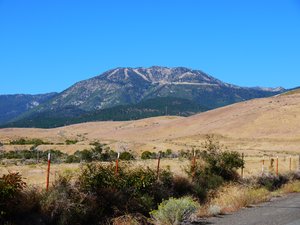

In [185]:
def get_wiki_image(wiki_url):
    response = requests.get(wiki_url)
    img = Image.open(BytesIO(response.content))
    wpercent = (300/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((300,hsize), Image.ANTIALIAS)
    return img

print(location_coords_wiki_summary[location_coords_city[0]])
get_wiki_image(location_coords_wiki_image[location_coords_city[0]])


In [208]:
#Reference: https://python-visualization.github.io/folium/quickstart.html
from folium.plugins import FloatImage
from folium import plugins

my_map = folium.Map(location = location_coords_map[0], zoom_start =6)

html = location_coords_wiki_summary[location_coords_city[i]]
iframe = folium.Html(html, script=True)
popup = folium.Popup(iframe,max_width=2650)


i=0
for location_in_route in location_coords_map:
    icon_number = plugins.BeautifyIcon(
            border_color='#00ABDC',
            text_color='#00ABDC',
            number=i+1,
            inner_icon_style='margin-top:0;')
    folium.Marker(location_in_route, 
                  popup = location_coords_city[i],
                  tooltip =location_coords_city[i], 
                  icon = icon_number
#                   icon=folium.Icon(color='green')
                 ).add_to(my_map)
#     FloatImage(location_coords_wiki_image[location_coords_city[i]]).add_to(my_map)
    i += 1

# loc = [tuple(location_coords), tuple(location_coords2)]
folium.PolyLine(list(location_coords_map),
                color='orange',
                weight=3,
                opacity=0.8).add_to(my_map)


my_map.save('myroute.html')

#Display the map
my_map

